## Intro to deep learning for medical imaging by [MD.ai](https://www.md.ai)

## Lesson 3. RSNA Pneumonia Detection Challenge (Kaggel API)

The [Radiological Society of North America](http://www.rsna.org/) Pneumonia Detection Challenge: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge

This notebook covers the basics of parsing the competition dataset, training using a detector basd on the [Mask-RCNN algorithm](https://arxiv.org/abs/1703.06870) for object detection and instance segmentation.  

This notebook is developed by [MD.ai](https://www.md.ai), the platform for medical AI. 
This notebook requires Google's [TensorFlow](https://www.tensorflow.org/) machine learning framework.

**Intro to deep learning for medical imaging lessons**

- Lesson 1. Classification of chest vs. adominal X-rays using TensorFlow/Keras [Github](https://github.com/mdai/ml-lessons/blob/master/lesson1-xray-images-classification.ipynb) [Annotator](https://public.md.ai/annotator/project/PVq9raBJ)

- Lesson 2. Lung X-Rays Semantic Segmentation using UNets. [Github](https://github.com/mdai/ml-lessons/blob/master/lesson2-lung-xrays-segmentation.ipynb)
[Annotator](https://public.md.ai/annotator/project/aGq4k6NW/workspace) 

- Lesson 3. RSNA Pneumonia detection using Kaggle data format [Github](https://github.com/mdai/ml-lessons/blob/master/lesson3-rsna-pneumonia-detection-kaggle.ipynb) [Annotator](https://public.md.ai/annotator/project/LxR6zdR2/workspace) 
  
- Lesson 3. RSNA Pneumonia detection using MD.ai python client library [Github](https://github.com/mdai/ml-lessons/blob/master/lesson3-rsna-pneumonia-detection-mdai-client-lib.ipynb) [Annotator](https://public.md.ai/annotator/project/LxR6zdR2/workspace) 

*Copyright 2018 MD.ai, Inc.   
Licensed under the Apache License, Version 2.0*

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:
import os
# Root directory of the project
#ROOT_DIR = os.path.abspath('./lesson3-data')
ROOT_DIR ='/content/gdrive/My Drive/Colab Notebooks'
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)
os.chdir(ROOT_DIR)

In [0]:
# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 


In [0]:
!pip3 install -q tqdm 
!pip3 install -q imgaug 

In [0]:
import os 
import sys

import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 

### First: Install Kaggle API for download competition data.

In [0]:
# Install Kaggle API for download competition data
#!pip3 install -q kaggle

### Next: You must accept the user agreement on the competition website! Then follow [instructions to obtain your Kaggle Credentials.](https://github.com/Kaggle/kaggle-api#api-credentials)  
If you are unable to download the competition dataset, check to see if you have accepted the **user agreement** on the competition website. 

In [0]:
# enter your Kaggle credentionals here
#os.environ['KAGGLE_USERNAME']=""
#os.environ['KAGGLE_KEY']=""

In [0]:
# Root directory of the project
#ROOT_DIR = os.path.abspath('./lesson3-data')
#ROOT_DIR ='/content/gdrive/My Drive/Colab Notebooks'
# Directory to save logs and trained model
#MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

#if not os.path.exists(ROOT_DIR):
#    os.makedirs(ROOT_DIR)
#os.chdir(ROOT_DIR)

In [0]:
# If you are unable to download the competition dataset, check to see if you have 
# accepted the user agreement on the competition website. 
#!kaggle competitions download -c rsna-pneumonia-detection-challenge

### Data is downloaded as zip files. Unzip the test and train datasets as well as the csv of  annotations.

In [0]:
# unzipping takes a few minutes
#!unzip -q -o stage_1_test_images.zip -d stage_1_test_images
#!unzip -q -o stage_1_train_images.zip -d stage_1_train_images
#!unzip -q -o stage_1_train_labels.csv.zip

###  MD.ai Annotator 

Additionally, If you are interested in augmenting the existing annotations, you can use the MD.ai annotator to view DICOM images, and create annotatios to be exported.  
MD.ai annotator project URL for the Kaggle dataset: https://public.md.ai/annotator/project/LxR6zdR2/workspace

**Annotator features**
- The annotator can be used to view DICOM images and create image and exam level annotations.
- You can apply the annotator to filter by label, adjudicate annotations, and assign annotation tasks to your team.
- Notebooks can be built directly within the annotator for rapid model development.
- The data wrangling is abstracted away by the interface and by our MD.ai library.
- Simplifies image annotation in order to widen the participation in the futrue of medical image deep learning.

The annotator allows you to create initial annotations, build and run models, modify/finetune the annotations based on predicted values, and repeat.  
The MD.ai python client library implements functions to easily download images and annotations and to prepare the datasets used to train the model for classification. See the following example notebook for parsing annotations and training using MD.ai annotator: 
https://github.com/mdai/ml-lessons/blob/master/lesson3-rsna-pneumonia-detection-mdai-client-lib.ipynb  
- MD.ai URL: https://www.md.ai  
- MD.ai documentation URL: https://docs.md.ai/

### Install Matterport's Mask-RCNN model from github.
See the [Matterport's implementation of Mask-RCNN](https://github.com/matterport/Mask_RCNN).

In [0]:
os.chdir(ROOT_DIR)
#!git clone https://github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')


In [12]:
!python setup.py -q install

zip_safe flag not set; analyzing archive contents...


In [13]:
!ls

assets	images	     mask_rcnn.egg-info  requirements.txt  setup.py
build	LICENSE      mrcnn		 samples
dist	MANIFEST.in  README.md		 setup.cfg


In [14]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [0]:
#train_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_train_images')
train_dicom_dir = os.path.join(ROOT_DIR, 'train')
#test_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_test_images')

### Some setup functions and classes for Mask-RCNN

- dicom_fps is a list of the dicom image path and filenames 
- image_annotions is a dictionary of the annotations keyed by the filenames
- parsing the dataset returns a list of the image filenames and the annotations dictionary

In [0]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [17]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8 
    
    BACKBONE = 'resnet101'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128
    
    RPN_ANCHOR_SCALES = (32, 64)
    
    TRAIN_ROIS_PER_IMAGE = 16
    
    MAX_GT_INSTANCES = 3
    
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_NMS_THRESHOLD = 0.1
    
    RPN_TRAIN_ANCHORS_PER_IMAGE = 16
    STEPS_PER_EPOCH = 100 
    TOP_DOWN_PYRAMID_SIZE = 32
    STEPS_PER_EPOCH = 100
    
    LEARNING_RATE=0.001
    
    LEARNING_MOMENTUM = 0.9
    #to get more region proposals during training
    POST_NMS_ROIS_TRAINING= 2500
    #DETECTION_MASK_THRESHOLD 
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [0]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
   
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

### Examine the annotation data, parse the dataset, and view dicom fields

In [19]:
# training dataset
anns = pd.read_csv(os.path.join(ROOT_DIR, 'stage_2_train_labels.csv'))
anns.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [20]:
anns['Target'].value_counts()

0    20672
1     9555
Name: Target, dtype: int64

In [0]:
#anns_normal=anns[anns['Target']==0]
anns_pneumonia=anns[anns['Target']==1]

In [22]:
print(anns_normal['Target'].value_counts())
print(anns_pneumonia['Target'].value_counts())

0    20672
Name: Target, dtype: int64
1    9555
Name: Target, dtype: int64


In [0]:
#subset_patients_0=anns_normal.sample(1000)
subset_patients_1=anns_pneumonia.sample(1000)

#frames = [subset_patients_0, subset_patients_1]
#result = pd.concat(frames)
result=anns_pneumonia.sample(1000)

In [24]:
result['Target'].value_counts()

1    1000
0    1000
Name: Target, dtype: int64

In [0]:
#random.shuffle(result.values)
result=result.iloc[np.random.permutation(len(result))]

In [26]:
result.head()


,patientId,x,y,width,height,Target
25447,e3f6c8b4-6647-4a84-aa33-50d06297be03,NaN,NaN,NaN,NaN,0
29649,1ffee791-10f6-4b8f-bfcd-35220e8e0003,609.0,405.0,256.0,179.0,1
18051,ab514814-ddbf-46df-b913-650244f68f48,497.0,271.0,251.0,520.0,1
5734,4936f212-84a2-41b0-8781-8652763f3cec,NaN,NaN,NaN,NaN,0
3492,38b557eb-bf26-4da1-b6ec-5674cddc9ef2,121.0,217.0,246.0,331.0,1


In [27]:
train_dicom_dir

'/content/gdrive/My Drive/Colab Notebooks/train'

In [0]:
#result['newList']=train_dicom_dir+result['patientId']+'*.dcm'
newList=[]
for value in result['patientId']: 
    temp=train_dicom_dir+'/'+value +'.dcm'
    newList.append(temp) 

In [29]:
newList[0:10]

['/content/gdrive/My Drive/Colab Notebooks/train/e3f6c8b4-6647-4a84-aa33-50d06297be03.dcm',
 '/content/gdrive/My Drive/Colab Notebooks/train/1ffee791-10f6-4b8f-bfcd-35220e8e0003.dcm',
 '/content/gdrive/My Drive/Colab Notebooks/train/ab514814-ddbf-46df-b913-650244f68f48.dcm',
 '/content/gdrive/My Drive/Colab Notebooks/train/4936f212-84a2-41b0-8781-8652763f3cec.dcm',
 '/content/gdrive/My Drive/Colab Notebooks/train/38b557eb-bf26-4da1-b6ec-5674cddc9ef2.dcm',
 '/content/gdrive/My Drive/Colab Notebooks/train/96009c90-cbf8-4c2c-8ba6-cccb0c107764.dcm',
 '/content/gdrive/My Drive/Colab Notebooks/train/9f756055-99fc-4a80-97b4-f89f98cf92d2.dcm',
 '/content/gdrive/My Drive/Colab Notebooks/train/590adf90-b0e6-40df-9500-85b6bfd85e21.dcm',
 '/content/gdrive/My Drive/Colab Notebooks/train/acef1ac8-98dc-4572-a646-4f7ca4b087f2.dcm',
 '/content/gdrive/My Drive/Colab Notebooks/train/9c5c063c-a4c2-4b07-8ed9-61fac3340dde.dcm']

In [30]:
result['newList']=newList
result.head(5)

,patientId,x,y,width,height,Target,newList
25447,e3f6c8b4-6647-4a84-aa33-50d06297be03,NaN,NaN,NaN,NaN,0,/content/gdrive/My Drive/Colab Notebooks/train...
29649,1ffee791-10f6-4b8f-bfcd-35220e8e0003,609.0,405.0,256.0,179.0,1,/content/gdrive/My Drive/Colab Notebooks/train...
18051,ab514814-ddbf-46df-b913-650244f68f48,497.0,271.0,251.0,520.0,1,/content/gdrive/My Drive/Colab Notebooks/train...
5734,4936f212-84a2-41b0-8781-8652763f3cec,NaN,NaN,NaN,NaN,0,/content/gdrive/My Drive/Colab Notebooks/train...
3492,38b557eb-bf26-4da1-b6ec-5674cddc9ef2,121.0,217.0,246.0,331.0,1,/content/gdrive/My Drive/Colab Notebooks/train...


In [0]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [0]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [33]:
# show dicom fields 
ds

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.16985.1517874400.710522
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: 'a1496b6c-e2f8-40be-a8bc-a48eb8258b60'
(0010, 0020) Patient ID                          LO: 'a1496b6c-e2f8-40be-a8bc-a48eb8258b60'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In [0]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

### Split the data into training and validation datasets
**Note: We have only used only a portion of the images for demonstration purposes. See comments below.**
 
 - To use all the images do: image_fps_list = list(image_fps)
 - Or change the number of images from 100 to a custom number

In [0]:
#image_fps[:10]

In [36]:
image_fps_list =list(result['newList'])
len(image_fps_list)

2000

In [37]:
######################################################################
# Modify this line to use more or fewer images for training/validation. 
# To use all images, do: image_fps_list = list(image_fps)
#image_fps_list = list(image_fps[:3000]) 
#####################################################################

# split dataset into training vs. validation dataset 
# split ratio is set to 0.9 vs. 0.1 (train vs. validation, respectively)
sorted(image_fps_list)
random.seed(42)
random.shuffle(image_fps_list)

validation_split = 0.1
split_index = int((1 - validation_split) * len(image_fps_list))

image_fps_train = image_fps_list[:split_index]
image_fps_val = image_fps_list[split_index:]

print(len(image_fps_train), len(image_fps_val))

1800 200


### Create and prepare the training dataset using the DetectorDataset class.

In [0]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

### Let's look at a sample annotation. We see a bounding box with (x, y) of the the top left corner as well as the width and height.

In [39]:
# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    f8a5a275-712b-433d-9578-84d44a87d062
 x                                             NaN
 y                                             NaN
 width                                         NaN
 height                                        NaN
 Target                                          0
 Name: 28044, dtype: object]

In [0]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

### Display a random image with bounding boxes

(1024, 1024, 3)
/content/gdrive/My Drive/Colab Notebooks/train/6cc1f886-40b7-4459-9e08-32d4e5c39276.dcm
[0]


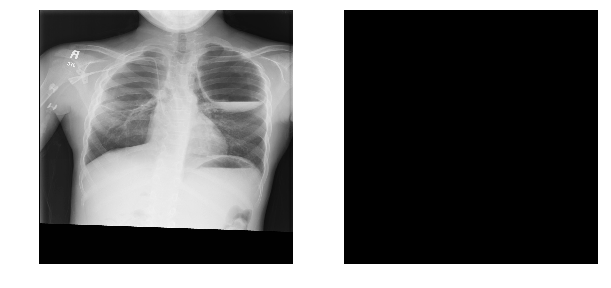

In [41]:
# Load and display random samples and their bounding boxes
# Suggestion: Run this a few times to see different examples. 

image_id = random.choice(dataset_train.image_ids)
image_fp = dataset_train.image_reference(image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

In [42]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)

W0711 13:12:21.037283 140573965969280 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0711 13:12:21.090397 140573965969280 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0711 13:12:21.128213 140573965969280 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0711 13:12:21.164886 140573965969280 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0711 13:12:21.170848 140573965

### Image Augmentation. Try finetuning some variables to custom values

In [0]:
# Image augmentation 
augmentation = iaa.SomeOf((0, 1), [
    iaa.Fliplr(0.5),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    ),
    iaa.Multiply((0.9, 1.1))
])

### Now it's time to train the model. Note that training even a basic model can take a few hours. 

Note: the following model is for demonstration purpose only. We have limited the training to one epoch, and have set nominal values for the Detector Configuration to reduce run-time. 

- dataset_train and dataset_val are derived from DetectorDataset 
- DetectorDataset loads images from image filenames and  masks from the annotation data
- model is Mask-RCNN

In [44]:
NUM_EPOCHS = 20

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")
hist= model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=NUM_EPOCHS, 
            layers='all',
            augmentation=augmentation)


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/gdrive/My Drive/Colab Notebooks/logs/pneumonia20190711T1312/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b   

W0711 13:12:35.330233 140573965969280 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0711 13:13:08.749945 140573965969280 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0711 13:13:08.751962 140573965969280 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/20
100/100 [==============================] - 420s 4s/step - loss: 3.3572 - rpn_class_loss: 0.5938 - rpn_bbox_loss: 1.0211 - mrcnn_class_loss: 0.3772 - mrcnn_bbox_loss: 0.7033 - mrcnn_mask_loss: 0.6618 - val_loss: 2.6691 - val_rpn_class_loss: 0.3945 - val_rpn_bbox_loss: 0.7972 - val_mrcnn_class_loss: 0.2975 - val_mrcnn_bbox_loss: 0.5797 - val_mrcnn_mask_loss: 0.6003
Epoch 2/20
100/100 [==============================] - 141s 1s/step - loss: 2.6206 - rpn_class_loss: 0.3606 - rpn_bbox_loss: 0.7790 - mrcnn_class_loss: 0.2989 - mrcnn_bbox_loss: 0.5992 - mrcnn_mask_loss: 0.5830 - val_loss: 2.5321 - val_rpn_class_loss: 0.3498 - val_rpn_bbox_loss: 0.8131 - val_mrcnn_class_loss: 0.2829 - val_mrcnn_bbox_loss: 0.5531 - val_mrcnn_mask_loss: 0.5333
Epoch 3/20
100/100 [==============================] - 213s 2s/step - loss: 2.4588 - rpn_class_loss: 0.3264 - rpn_bbox_loss: 0.6944 - mrcnn_class_loss: 0.2986 - mrcnn_bbox_loss: 0.5720 - mrcnn_mask_loss: 0.5675 - val_loss: 2.4037 - val_rpn_class_l

In [55]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else: 
      
      checkpoint = os.path.join(dir_name, checkpoints[-1])
      fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))
model.load_weights(model_path, by_name=True)

Found model /content/gdrive/My Drive/Colab Notebooks/logs/pneumonia20190711T1312/mask_rcnn_pneumonia_0020.h5
Re-starting from epoch 20


In [56]:
print('Config Learning Rate :',config.LEARNING_RATE)
New_Learning_Rate =config.LEARNING_RATE*0.1
print('Newer Learning Rate',New_Learning_Rate)

Config Learning Rate : 0.001
Newer Learning Rate 0.0001


In [1]:
NUM_EPOCHS = 20

# Train Mask-RCNN Model 
#import warnings 
#model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)
#warnings.filterwarnings("ignore")
hist_1= model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE*0.1, 
            epochs=20, 
            layers='all',
            augmentation=augmentation)

NameError: ignored

In [47]:
print('Config Learning Rate :',config.LEARNING_RATE)
New_Learning_Rate =New_Learning_Rate/5
print('Newer Learning Rate',New_Learning_Rate)

Config Learning Rate : 0.001
Newer Learning Rate 2e-05


In [48]:
NUM_EPOCHS = 20

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")
hist= model.train(dataset_train, dataset_val, 
            learning_rate=New_Learning_Rate, 
            epochs=NUM_EPOCHS, 
            layers='all',
            augmentation=augmentation)


Starting at epoch 20. LR=2e-05

Checkpoint Path: /content/gdrive/My Drive/Colab Notebooks/logs/pneumonia20190711T1312/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b  

In [49]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else: 
      
      checkpoint = os.path.join(dir_name, checkpoints[-1])
      fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model /content/gdrive/My Drive/Colab Notebooks/logs/pneumonia20190711T1312/mask_rcnn_pneumonia_0020.h5


In [0]:
model.load_weights(model_path, by_name=True)

In [0]:
plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, hist["loss"], label="Train loss")
plt.plot(epochs, hist["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, hist["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, hist["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, hist["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, hist["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()

In [51]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

W0711 14:32:31.854449 140573965969280 deprecation_wrapper.py:119] From /content/gdrive/My Drive/Colab Notebooks/Mask_RCNN/mrcnn/model.py:720: The name tf.sets.set_intersection is deprecated. Please use tf.sets.intersection instead.

W0711 14:32:32.371232 140573965969280 deprecation.py:323] From /content/gdrive/My Drive/Colab Notebooks/Mask_RCNN/mrcnn/model.py:772: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


Loading weights from  /content/gdrive/My Drive/Colab Notebooks/logs/pneumonia20190711T1312/mask_rcnn_pneumonia_0020.h5
Re-starting from epoch 20


In [0]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

### How does the predicted box compared to the expected value? Let's use the validation dataset to check. 

Note that we trained only one epoch for **demonstration purposes ONLY**. You might be able to improve performance running more epochs. 


*** No instances to display *** 


*** No instances to display *** 



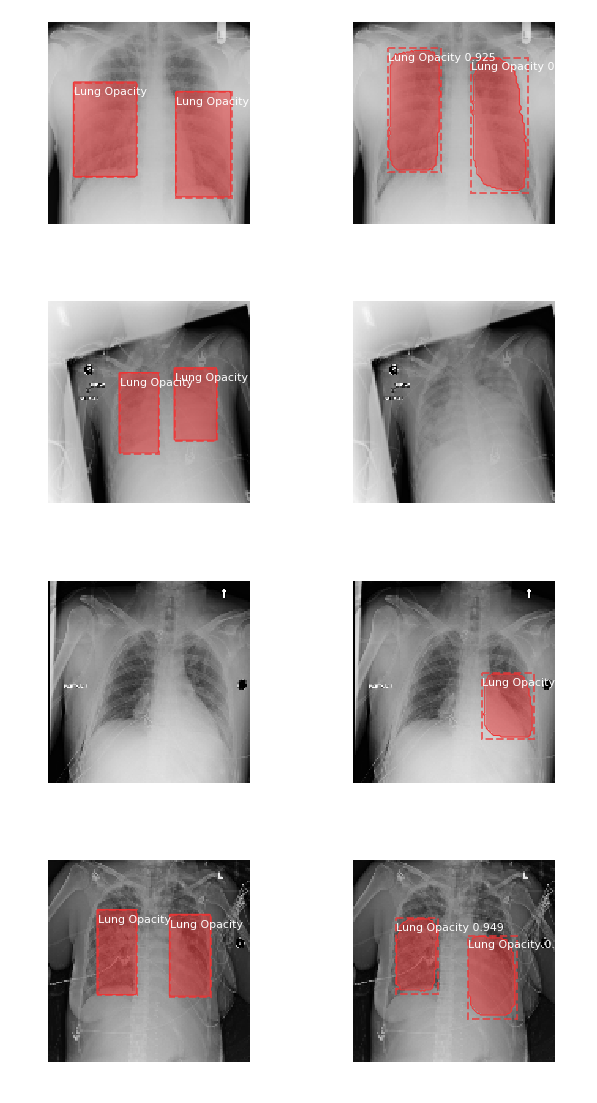

In [53]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(4):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
        
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

In [54]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)

NameError: ignored

### Final steps - Create the submission file

In [0]:
# Make predictions on test images, write out sample submission 
def predict(image_fps, filepath='sample_submission.csv', min_conf=0.98): 
    
    # assume square image
    
    with open(filepath, 'w') as file:
      for image_id in tqdm(image_fps): 
        ds = pydicom.read_file(image_id)
        image = ds.pixel_array
          
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1) 
            
        patient_id = os.path.splitext(os.path.basename(image_id))[0]

        results = model.detect([image])
        r = results[0]

        out_str = ""
        out_str += patient_id 
        assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
        if len(r['rois']) == 0: 
            pass
        else: 
            num_instances = len(r['rois'])
            out_str += ","
            for i in range(num_instances): 
                if r['scores'][i] > min_conf: 
                    out_str += ' '
                    out_str += str(round(r['scores'][i], 2))
                    out_str += ' '

                    # x1, y1, width, height 
                    x1 = r['rois'][i][1]
                    y1 = r['rois'][i][0]
                    width = r['rois'][i][3] - x1 
                    height = r['rois'][i][2] - y1 
                    bboxes_str = "{} {} {} {}".format(x1, y1, \
                                                      width, height)    
                    out_str += bboxes_str

        file.write(out_str+"\n")

In [0]:
# predict only the first 50 entries
sample_submission_fp = 'sample_submission.csv'
predict(test_image_fps[:50], filepath=sample_submission_fp)

In [0]:
output = pd.read_csv(sample_submission_fp, names=['id', 'pred_string'])
output.head(50)